# TODO

- [x] MI with mentions as target given bitcoin
- [x] Analyse crypto mentions
- [ ] Pointwise analysis for mentions -> doge
- [ ] Review all graphs axis and legends
- [ ] Add stat sig graphs to all grid searches
- [ ] Use volumes instead of price
- [ ] Analyse other alter coins vs bitcoin

# Imports and Configs

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import pprint as pp
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

In [2]:
# conda install -c conda-forge jpype1
from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/Users/gilmar/opensource/jidt/demos/python")
import readFloatsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/Users/gilmar/opensource/jidt/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation, convertStrings=True)

# Utility Functions

Prints stats from dataframe or timeseries

In [3]:
def inspect_df(df, txt='Dataframe Information', date_col='date', timeseries=False, col_prefix=None, sep_size=80):
    print('=' * sep_size)
    print(txt)
    print('=' * sep_size)
    date_range_counts_label = 'Dates Range and Row Count'
    print(date_range_counts_label)
    print('-' * len(date_range_counts_label))
    agg_df =  df
    date_col = col_prefix + date_col if col_prefix else date_col
    if not timeseries:
        agg_df =  df[date_col]
    pp.pprint(agg_df.agg(['min','max','count']))
    print('-' * sep_size)
    pp.pprint(df.info())

Given a timeseries, applies a logarithmic transformation and computes the difference between consecutive log-transformed values.

In [4]:
def log_difference(series):
    log_series = np.log(series)
    log_diff_series = log_series.diff().dropna()
    return log_diff_series

Performs the [Augmented Dickey-Fuller (ADF)](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test) test wether or not the series is stationary

In [5]:
def dickey_fuller_test_stationarity(series):
    result = adfuller(series)
    p_value = result[1]
    return True if p_value < 0.05 else False

In [6]:
def inspect_stationarity(df):
    for col in df.columns:
        test_res = 'stationary' if dickey_fuller_test_stationarity(df[col]) else 'non-stationary'
        print('{} is {}'.format(col, test_res))

Discretise a time series based on standard deviations from the mean.

In [7]:
def discretise_by_std(series, num_std=2):
    mean = series.mean()
    std = series.std()
    # Define bin edges based on standard deviations
    bin_edges = [-np.inf] + [mean - i * std for i in range(num_std, 0, -1)] + \
                [mean + i * std for i in range(1, num_std + 1)] + [np.inf]

    # Define bin labels
    bin_labels = [i for i in range(len(bin_edges) - 1)]

    # Categorize each data point into a bin
    discretised_series = pd.cut(series, bins=bin_edges, labels=bin_labels)

    return discretised_series

Compute result and statistical significancy

In [8]:
def compute_estimate_and_stat_sig(source, destination, calc, surrogate_perms=100, conditional=None, discrete=False):
    # 3. Initialise the calculator for (re-)use:
    calc.initialise()
    # 4. Supply the sample data:
    if conditional:
        if discrete:
            calc.addObservations(source, destination, conditional)
        else:
            calc.setObservations(source, destination, conditional)
    else:
        if discrete:
            calc.addObservations(source, destination)
        else:
            calc.setObservations(source, destination)
    
    # 5. Compute the estimate:
    result = calc.computeAverageLocalOfObservations()
    # 6. Compute the (statistical significance via) null distribution empirically (e.g. with 1000 permutations):
    measDist = calc.computeSignificance(surrogate_perms)
    return result, measDist

Run a grid search for best k and time lag given a source and destination series and a calculator

In [9]:
def grid_search_k_timediff(source, destination, calc, surrogate_perms=100):
    results = []
    time_diffs = range(0,30)
    ks = range(4,6)

    for time_diff in time_diffs:
        for k in ks:
            # Set TIME_DIFF and k properties
            calc.setProperty("TIME_DIFF", str(time_diff))
            calc.setProperty("k", str(k))
            result, measDist = compute_estimate_and_stat_sig(source, destination, calc, surrogate_perms)
            results.append([time_diff,k,result,measDist.pValue])
    
    grid_search_results_df = pd.DataFrame(results)
    grid_search_results_df.columns = ['time_diff','k', 'mi', 'p_value']
    
    return grid_search_results_df

In [10]:
def discrete_grid_search_timediff(source, destination, surrogate_perms=100):
    results = []
    time_diffs = range(0,30)

    for time_diff in time_diffs:
            calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
            calc = calcClass(10, 10, time_diff)
            result, measDist = compute_estimate_and_stat_sig(source, destination, calc, \
                                                             surrogate_perms, discrete=True)
            results.append([time_diff,result,measDist.pValue])
            
            
    grid_search_results_df = pd.DataFrame(results)
    grid_search_results_df.columns = ['time_diff', 'mi', 'p_value']
    
    return grid_search_results_df

Extract best mutual information from grid search result

In [11]:
def extract_best_result(grid_search_results_df):
    return grid_search_results_df.iloc[grid_search_results_df['mi'].idxmax()]

---

# Inspect Initial Data

In [12]:
original_df = pd.read_csv('data/tweets_doge_bitcoin.csv')
original_df['date'] = pd.to_datetime(original_df.date)
original_df = original_df.set_index('date')

In [13]:
inspect_df(original_df, timeseries=True)

Dataframe Information
Dates Range and Row Count
-------------------------
       bitcoin_close  bitcoin_volume  dogecoin_close  dogecoin_volume  \
min          3211.72     1254.292531        0.001038          1431720   
max         67525.83   760705.362783        0.684777      69410680685   
count        2059.00     2059.000000     2059.000000             2059   

       dogecoin_mentions  crypto_mentions  dogecoin_mention_polarity_score  
min                  0.0              0.0                          -0.5106  
max                  4.0              6.0                           1.6413  
count             2059.0           2059.0                        2059.0000  
--------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2059 entries, 2017-11-09 to 2023-06-29
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  ----

In [14]:
original_df

,bitcoin_close,bitcoin_volume,dogecoin_close,dogecoin_volume,dogecoin_mentions,crypto_mentions,dogecoin_mention_polarity_score
date,,,,,,,
2017-11-09,7079.99,1913.398308,0.001415,6259550,0.0,0.0,0.0
2017-11-10,6506.98,3254.704105,0.001163,4246520,0.0,0.0,0.0
2017-11-11,6245.05,2754.156861,0.001201,2231080,0.0,0.0,0.0
2017-11-12,5811.03,4968.483069,0.001038,3288960,0.0,0.0,0.0
2017-11-13,6465.99,2621.243039,0.001211,2481270,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-25,30462.66,30223.448010,0.066764,191028870,0.0,0.0,0.0
2023-06-26,30267.99,45180.414890,0.064749,266917426,0.0,0.0,0.0
2023-06-27,30692.44,42699.641570,0.065545,212409649,0.0,0.0,0.0


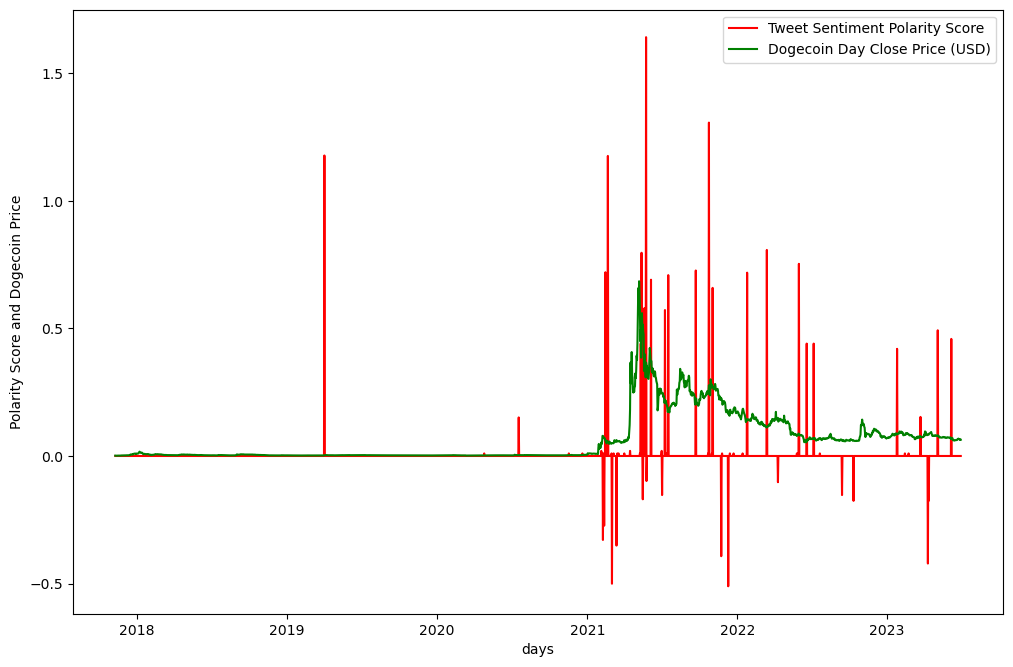

In [15]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, original_df['dogecoin_mention_polarity_score'].values\
         , color='red', label='Tweet Sentiment Polarity Score')
plt.plot(original_df.index, original_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Polarity Score and Dogecoin Price')
plt.legend()

<AxesSubplot:>

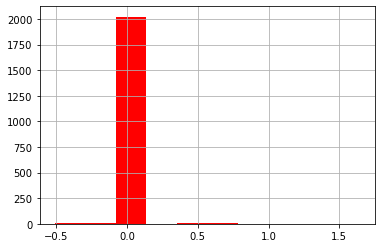

In [16]:
original_df['dogecoin_mention_polarity_score'].hist(color='red')

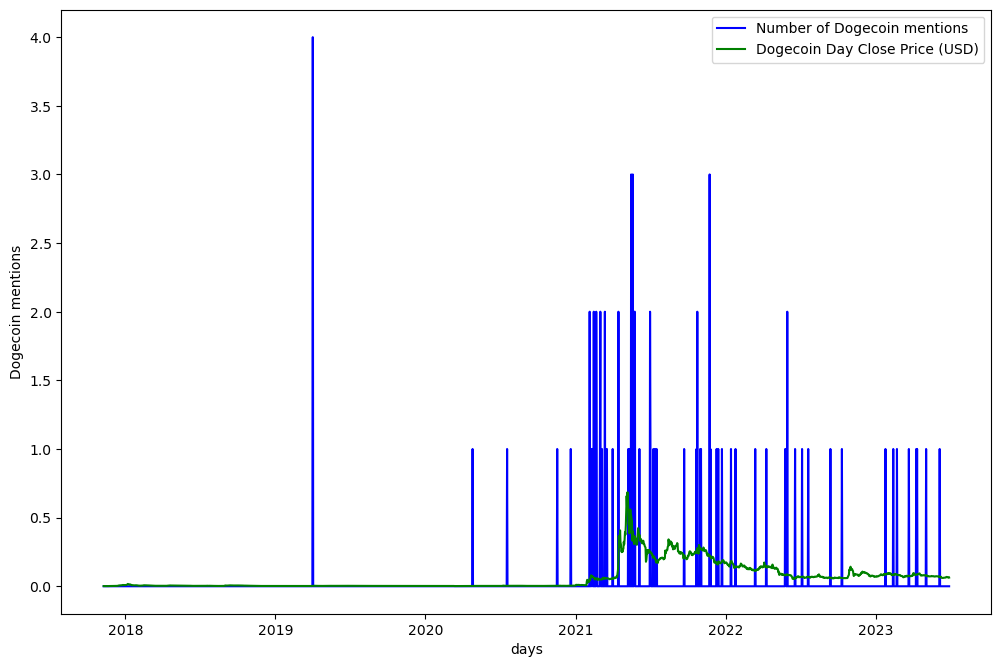

In [17]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, original_df['dogecoin_mentions'].values\
         , color='blue', label='Number of Dogecoin mentions')
plt.plot(original_df.index, original_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Dogecoin mentions')
plt.legend()

<AxesSubplot:>

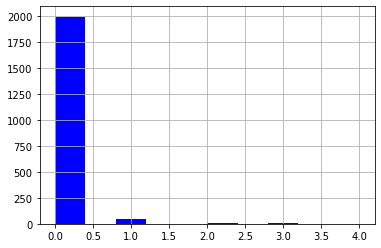

In [18]:
original_df['dogecoin_mentions'].hist(color='blue')

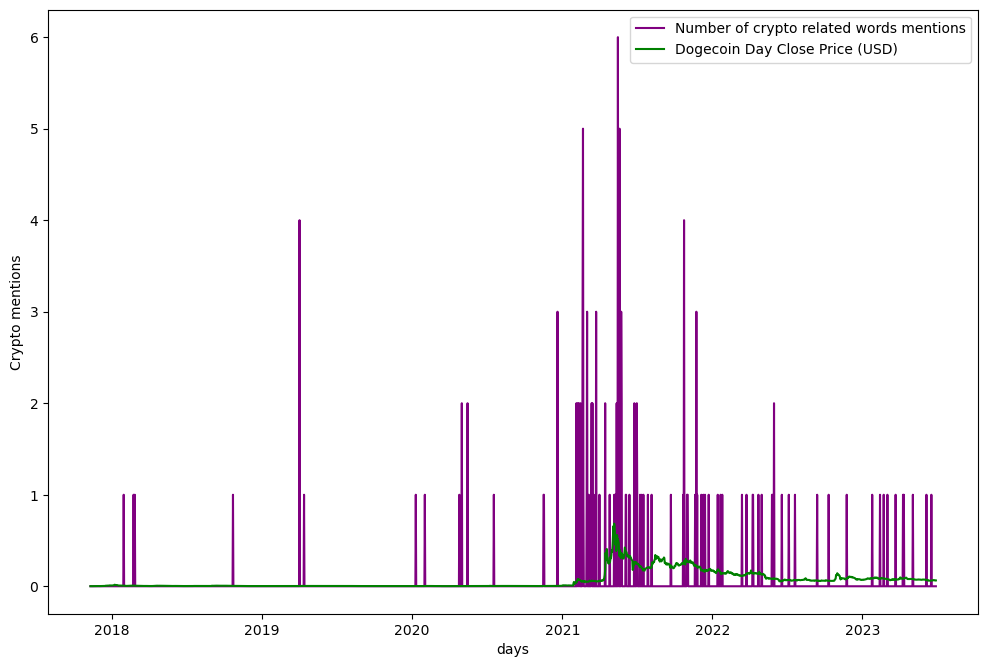

In [19]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, original_df['crypto_mentions'].values\
         , color='purple', label='Number of crypto related words mentions')
plt.plot(original_df.index, original_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Crypto mentions')
plt.legend()

<AxesSubplot:>

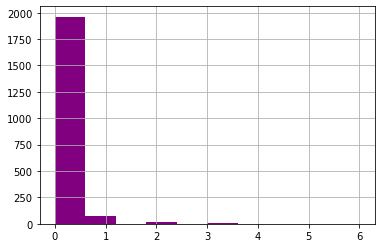

In [20]:
original_df['crypto_mentions'].hist(color='purple')

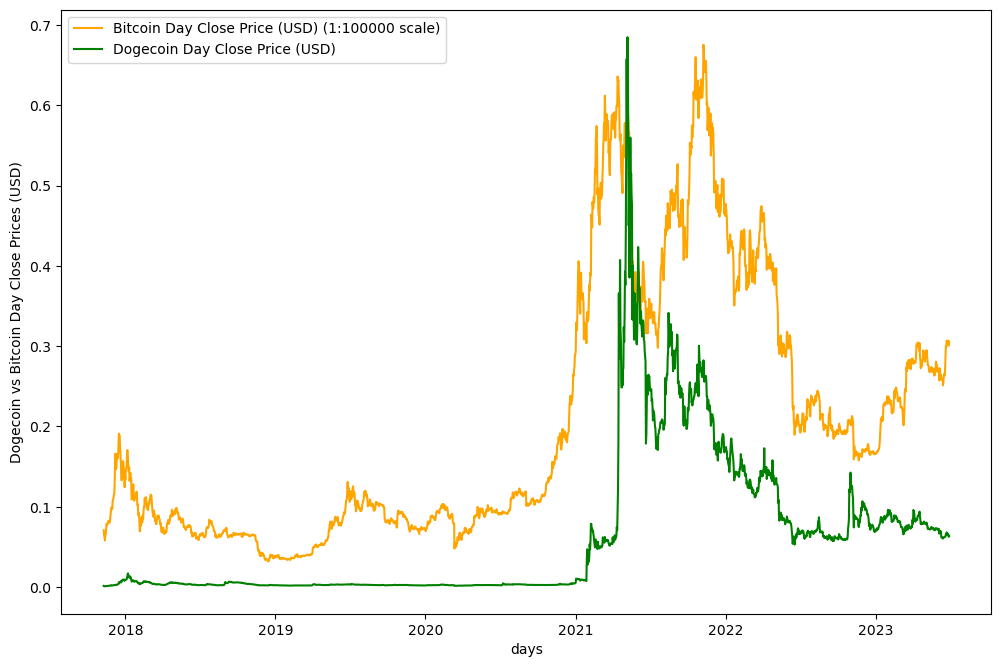

In [21]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, (original_df['bitcoin_close'].values / 100000)\
         , color='orange', label='Bitcoin Day Close Price (USD) (1:100000 scale)')
plt.plot(original_df.index, original_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Dogecoin vs Bitcoin Day Close Prices (USD)')
plt.legend()

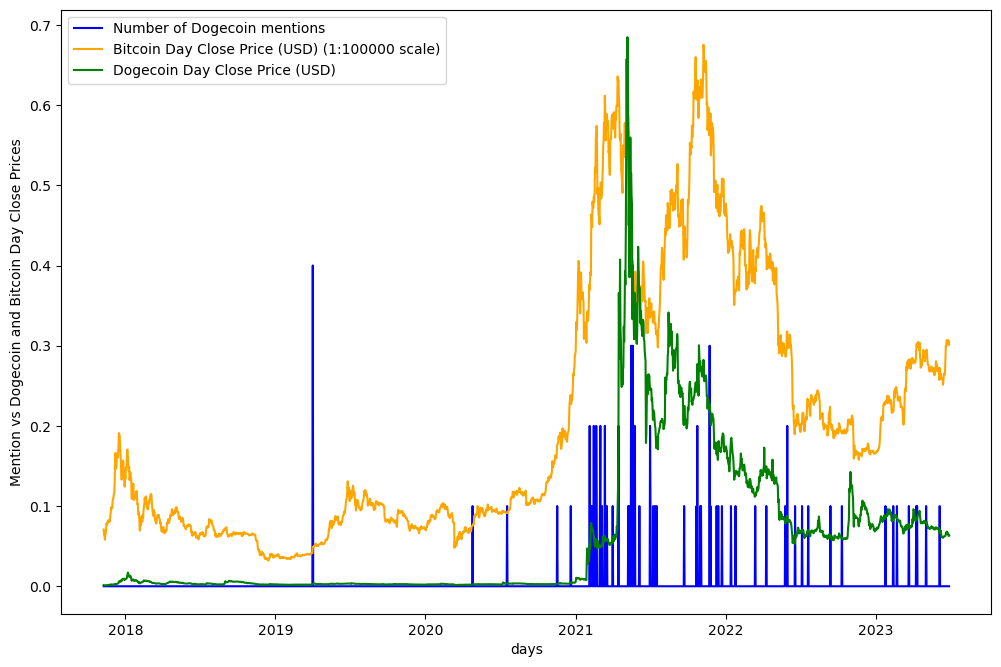

In [22]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, original_df['dogecoin_mentions'].values /10 \
         , color='blue', label='Number of Dogecoin mentions')
plt.plot(original_df.index, (original_df['bitcoin_close'].values / 100000)\
         , color='orange', label='Bitcoin Day Close Price (USD) (1:100000 scale)')
plt.plot(original_df.index, original_df['dogecoin_close'].values\
         , color='green', label='Dogecoin Day Close Price (USD)')
plt.xlabel('days')
plt.ylabel('Mention vs Dogecoin and Bitcoin Day Close Prices')
plt.legend()

<AxesSubplot:>

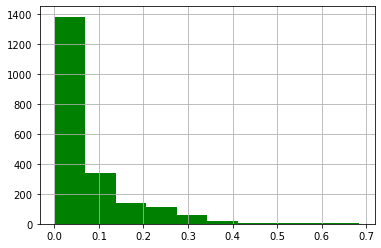

In [23]:
original_df['dogecoin_close'].hist(color='green')

<AxesSubplot:>

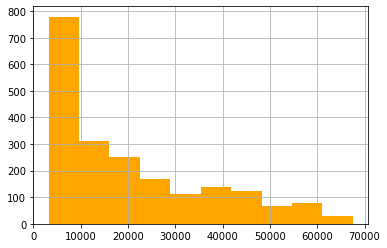

In [24]:
original_df['bitcoin_close'].hist(color='orange')

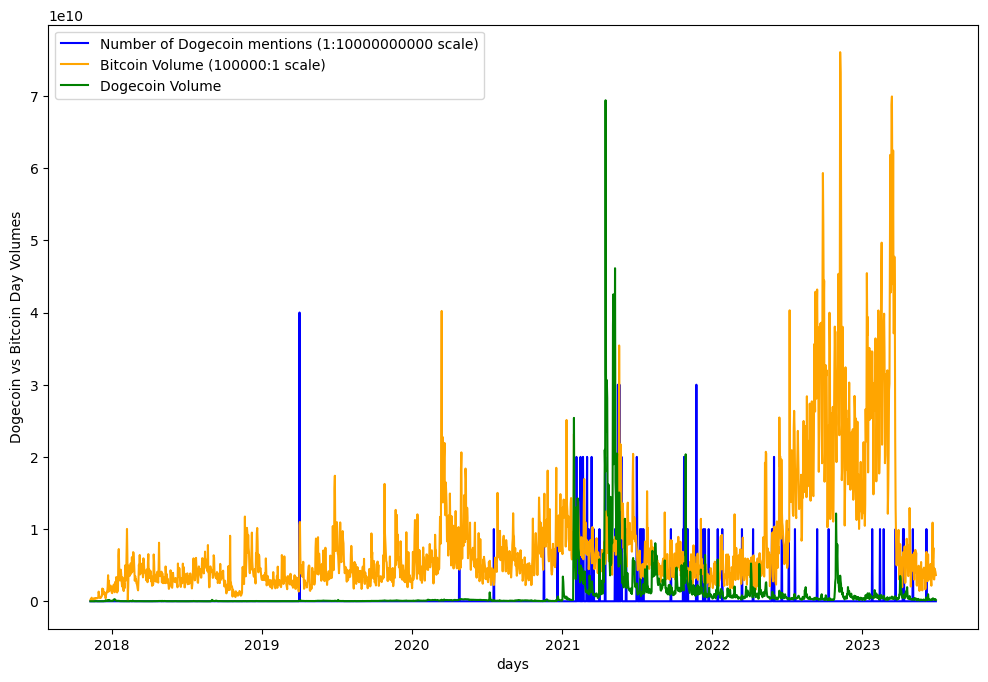

In [25]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(original_df.index, original_df['dogecoin_mentions'].values * 10000000000\
         , color='blue', label='Number of Dogecoin mentions (1:10000000000 scale)')
plt.plot(original_df.index, (original_df['bitcoin_volume'].values * 100000)\
         , color='orange', label='Bitcoin Volume (100000:1 scale)')
plt.plot(original_df.index, original_df['dogecoin_volume'].values\
         , color='green', label='Dogecoin Volume')
plt.xlabel('days')
plt.ylabel('Dogecoin vs Bitcoin Day Volumes')
plt.legend()

## Checking for stationarity and Autocorrelation

In [26]:
inspect_stationarity(original_df)

bitcoin_close is non-stationary
bitcoin_volume is stationary
dogecoin_close is non-stationary
dogecoin_volume is stationary
dogecoin_mentions is stationary
crypto_mentions is stationary
dogecoin_mention_polarity_score is stationary


The dataset is highly non-stationary - aside from the large autocorrelation, the dogecoin is operating in a completely different magnitude from half way through the time series.

### Sentiment Polarity Score Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

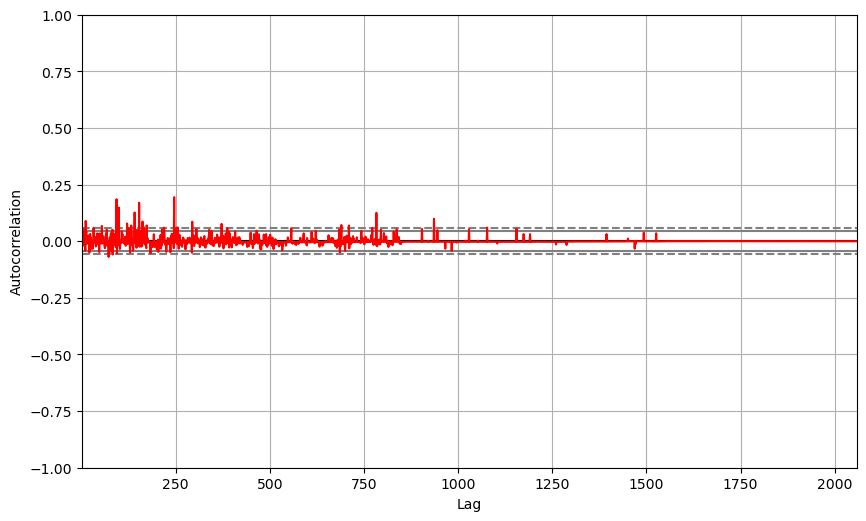

In [27]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(original_df['dogecoin_mention_polarity_score'], color='red')

### Mentions Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

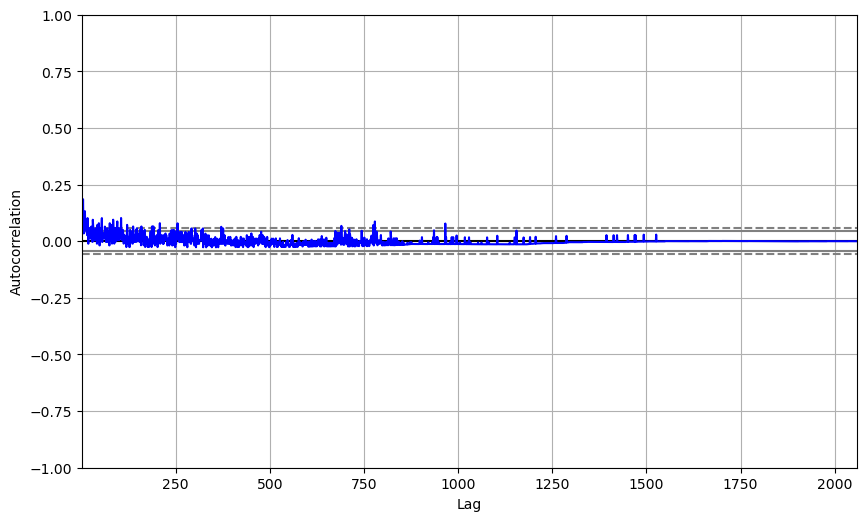

In [28]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(original_df['dogecoin_mentions'], color='blue')

### Dogecoin Close Price Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

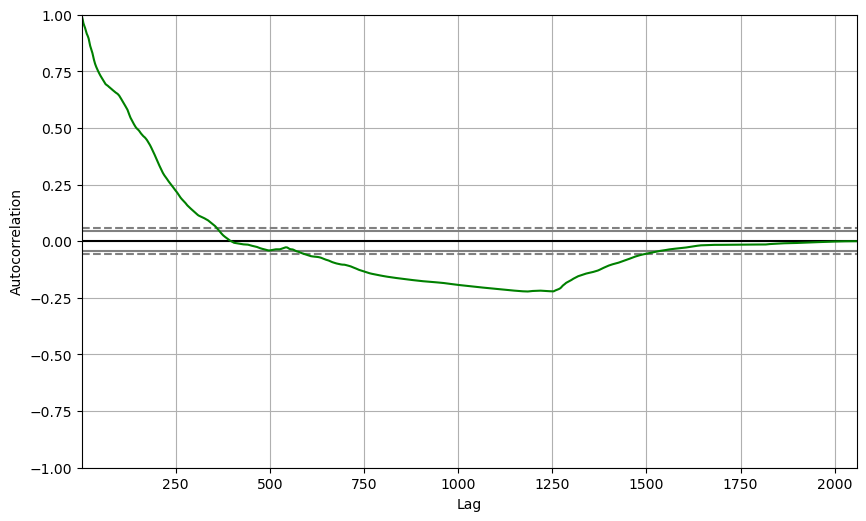

In [29]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(original_df['dogecoin_close'], color='green')

### Bitcoin Close Price Autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

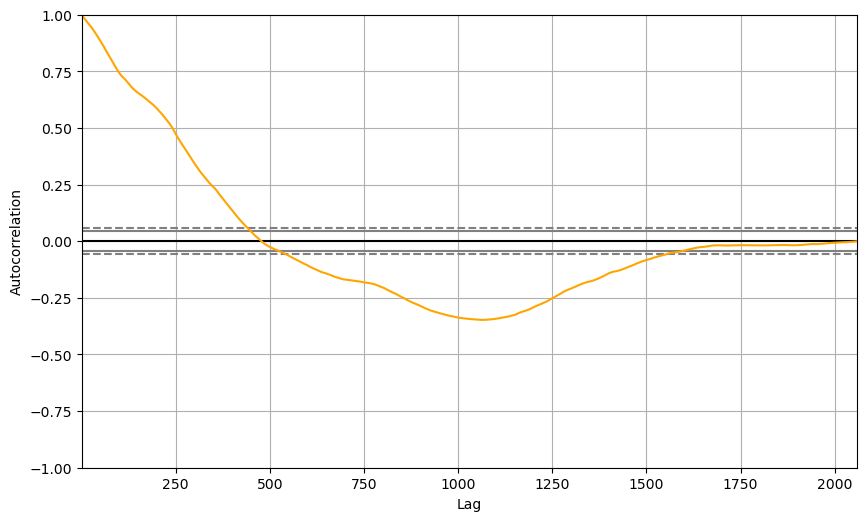

In [30]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(original_df['bitcoin_close'], color='orange')

# Applying log differences

When comparing two time series where one is highly non-stationary and both exhibit significant autocorrelation and a shift in magnitude partway through the series, using log-differences can be a helpful approach. 

In [31]:
new_df_dict = {}
for col in original_df.columns:
    if dickey_fuller_test_stationarity(original_df[col]):
        # if stationary, just copy removing first day
        new_df_dict[col] = original_df[col].tail(-1) 
    else:
        # create new column with log diff
        new_df_dict[col + '_logdiff'] = log_difference(original_df[col])
        # copy original column, removing first day
        new_df_dict[col] = original_df[col].tail(-1)
    # to reindex removing first day
    new_df_dict['date'] = original_df.index.delete(0)
stationary_df = pd.DataFrame.from_dict(new_df_dict).set_index('date')

In [32]:
inspect_stationarity(stationary_df)

bitcoin_close_logdiff is stationary
bitcoin_close is non-stationary
bitcoin_volume is stationary
dogecoin_close_logdiff is stationary
dogecoin_close is non-stationary
dogecoin_volume is stationary
dogecoin_mentions is stationary
crypto_mentions is stationary
dogecoin_mention_polarity_score is stationary


In [33]:
inspect_df(stationary_df, timeseries=True)

Dataframe Information
Dates Range and Row Count
-------------------------
       bitcoin_close_logdiff  bitcoin_close  bitcoin_volume  \
min                -0.502607        3211.72     1254.292531   
max                 0.202952       67525.83   760705.362783   
count            2058.000000        2058.00     2058.000000   

       dogecoin_close_logdiff  dogecoin_close  dogecoin_volume  \
min                 -0.515118        0.001038          1431720   
max                  1.516328        0.684777      69410680685   
count             2058.000000     2058.000000             2058   

       dogecoin_mentions  crypto_mentions  dogecoin_mention_polarity_score  
min                  0.0              0.0                          -0.5106  
max                  4.0              6.0                           1.6413  
count             2058.0           2058.0                        2058.0000  
--------------------------------------------------------------------------------
<class 'pandas.core

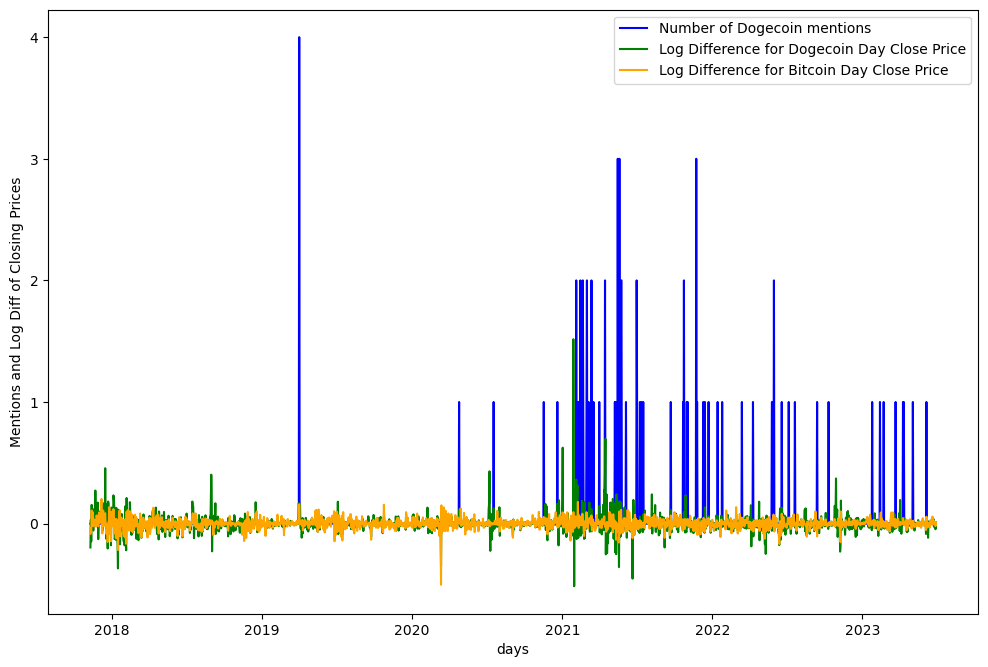

In [34]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(stationary_df.index, stationary_df['dogecoin_mentions'].values\
         , color='blue', label='Number of Dogecoin mentions')
plt.plot(stationary_df.index, stationary_df['dogecoin_close_logdiff'].values\
         , color='green', label='Log Difference for Dogecoin Day Close Price')
plt.plot(stationary_df.index, stationary_df['bitcoin_close_logdiff'].values\
         , color='orange', label='Log Difference for Bitcoin Day Close Price')
plt.xlabel('days')
plt.ylabel('Mentions and Log Diff of Closing Prices')
plt.legend()

<AxesSubplot:>

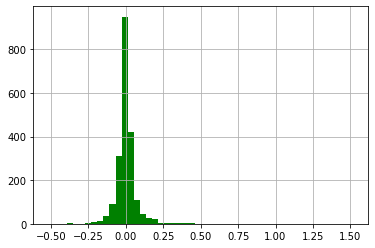

In [35]:
stationary_df['dogecoin_close_logdiff'].hist(color='green', bins=50)

<AxesSubplot:>

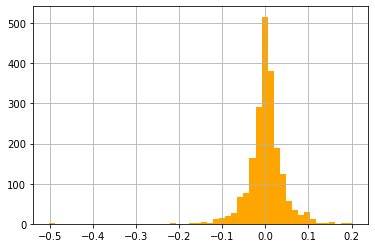

In [36]:
stationary_df['bitcoin_close_logdiff'].hist(color='orange', bins=50)

### Dogecoin log diff autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

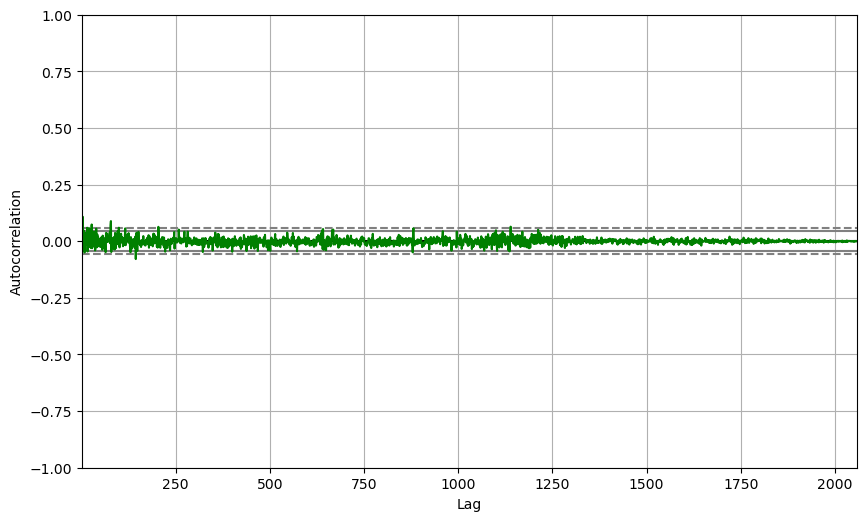

In [37]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(stationary_df['dogecoin_close_logdiff'], color='green')

### Dogecoin log diff autocorrelation

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

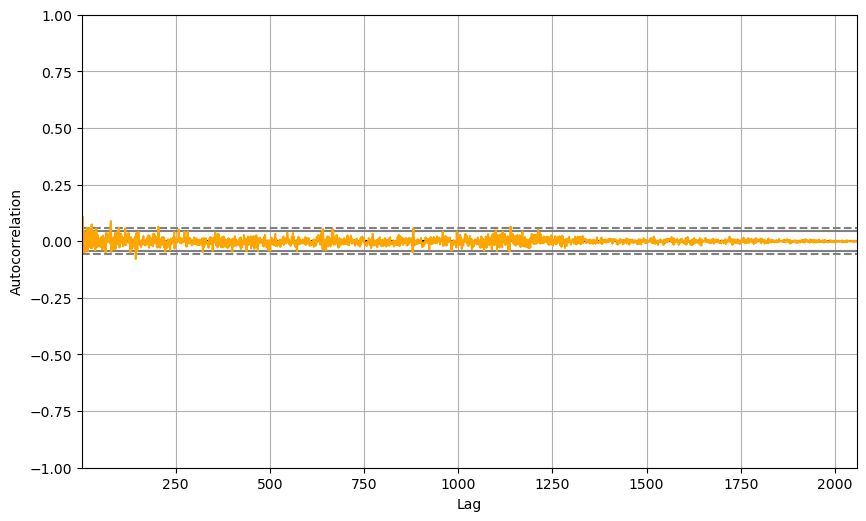

In [38]:
fig=plt.figure(figsize=(10,6), dpi= 100, facecolor='w', edgecolor='k')
pd.plotting.autocorrelation_plot(stationary_df['dogecoin_close_logdiff'], color='orange')

No autocorrelation observed when working with log difference of coin prices.

# Discretising series

In [39]:
discrete_stationary_df = stationary_df.copy()
discrete_stationary_df['dogecoin_close_logdiff_discrete'] = \
    discretise_by_std(stationary_df['dogecoin_close_logdiff'])
discrete_stationary_df['bitcoin_close_logdiff_discrete'] = \
    discretise_by_std(stationary_df['bitcoin_close_logdiff'])

In [40]:
inspect_df(discrete_stationary_df, timeseries=True)

Dataframe Information
Dates Range and Row Count
-------------------------
       bitcoin_close_logdiff  bitcoin_close  bitcoin_volume  \
min                -0.502607        3211.72     1254.292531   
max                 0.202952       67525.83   760705.362783   
count            2058.000000        2058.00     2058.000000   

       dogecoin_close_logdiff  dogecoin_close  dogecoin_volume  \
min                 -0.515118        0.001038          1431720   
max                  1.516328        0.684777      69410680685   
count             2058.000000     2058.000000             2058   

       dogecoin_mentions  crypto_mentions  dogecoin_mention_polarity_score  \
min                  0.0              0.0                          -0.5106   
max                  4.0              6.0                           1.6413   
count             2058.0           2058.0                        2058.0000   

       dogecoin_close_logdiff_discrete  bitcoin_close_logdiff_discrete  
min                   

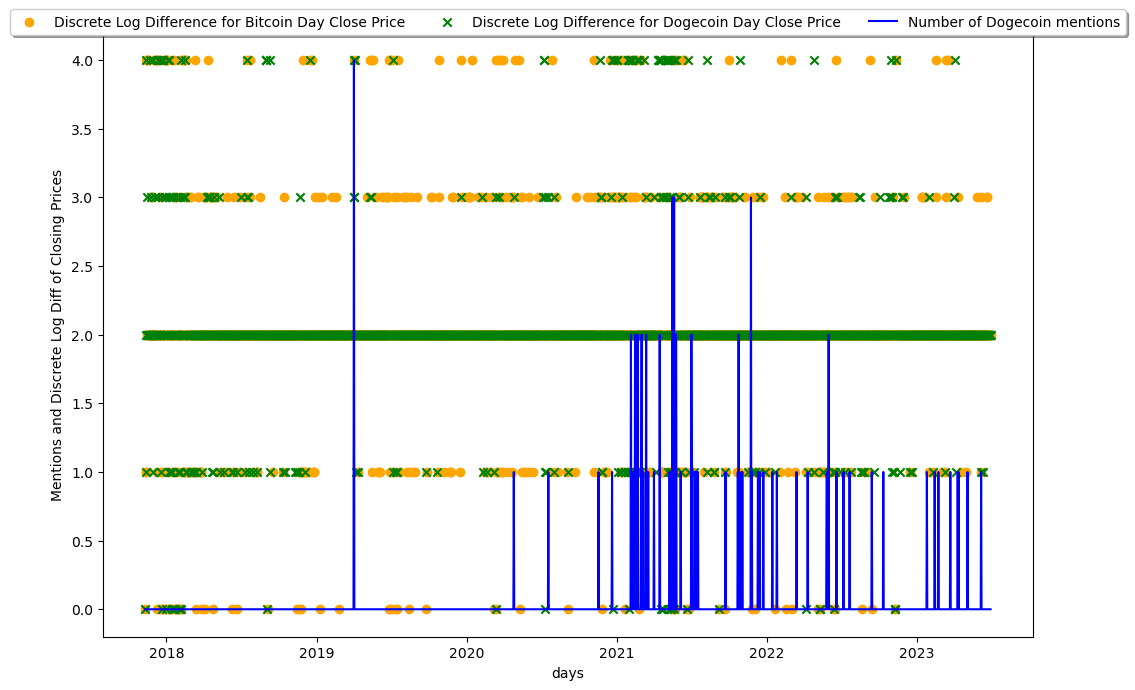

In [66]:
fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(discrete_stationary_df.index\
            , discrete_stationary_df['bitcoin_close_logdiff_discrete'].values\
            , color='orange'\
            , marker='o'
            , label='Discrete Log Difference for Bitcoin Day Close Price')
plt.scatter(discrete_stationary_df.index\
            , discrete_stationary_df['dogecoin_close_logdiff_discrete'].values\
            , color='green'\
            , marker='x'
            , label='Discrete Log Difference for Dogecoin Day Close Price')
plt.plot(discrete_stationary_df.index\
            , discrete_stationary_df['dogecoin_mentions'].values\
            , color='blue'\
            , label='Number of Dogecoin mentions')
plt.xlabel('days')
plt.ylabel('Mentions and Discrete Log Diff of Closing Prices')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)

<AxesSubplot:>

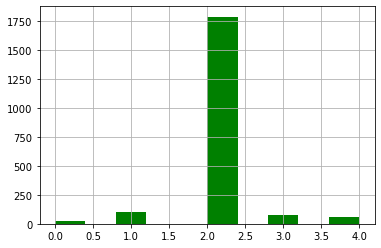

In [42]:
discrete_stationary_df['dogecoin_close_logdiff_discrete'].hist(color='green')

<AxesSubplot:>

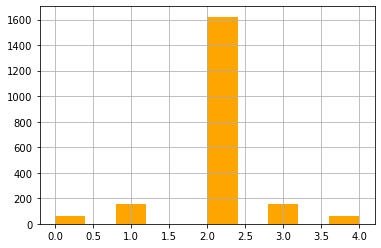

In [43]:
discrete_stationary_df['bitcoin_close_logdiff_discrete'].hist(color='orange')

---

# Information Theory Analysis

## Prepare data for JIDT

### Save TXT

#### Mentions

In [44]:
discrete_stationary_df[['dogecoin_mentions', 'dogecoin_close_logdiff_discrete', 'bitcoin_close_logdiff_discrete']]\
    .astype({"dogecoin_mentions":"int64"\
             ,"dogecoin_close_logdiff_discrete":"int64"\
             ,"bitcoin_close_logdiff_discrete":"int64"})\
    .to_csv('data/mentions_doge_bitcoin_close.txt', sep='\t', header=False, index=False)

#### Sentiment Polarity Score

In [45]:
stationary_df[['dogecoin_mention_polarity_score', 'dogecoin_close_logdiff', 'bitcoin_close_logdiff']]\
    .to_csv('data/polarity_doge_bitcoin_close.txt', sep='\t', header=False, index=False)

### Load data

In [46]:
# 0. Load/prepare the data:
discrete_dataRaw = readFloatsFile.readFloatsFile("data/mentions_doge_bitcoin_close.txt")
# As numpy array:
discrete_data = numpy.array(discrete_dataRaw).astype(np.int64)

In [47]:
# 0. Load/prepare the data:
stationary_dataRaw = readFloatsFile.readFloatsFile("data/mentions_doge_bitcoin_close.txt")
# As numpy array:
stationary_data = numpy.array(stationary_dataRaw)

In [48]:
mentions = JArray(JInt, 1)(discrete_data[:,0].tolist())
discrete_dogecoin = JArray(JInt, 1)(discrete_data[:,1].tolist())
discrete_bitcoin = JArray(JInt, 1)(discrete_data[:,2].tolist())

In [49]:
polarity = JArray(JDouble, 1)(stationary_data[:,0].tolist())
stationary_dogecoin = JArray(JDouble, 1)(stationary_data[:,1].tolist())
stationary_bitcoin = JArray(JDouble, 1)(stationary_data[:,2].tolist())

# Discrete Estimator

##  Discrete MI : Mentions -> Dogecoin 

### Discrete Grid Search for time diff

In [50]:
mentions_doge_calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete

In [51]:
mentions_doge_grid_search_results_df = \
    discrete_grid_search_timediff(source = mentions\
                                  , destination = discrete_dogecoin\
                                  , surrogate_perms=100)

In [52]:
extract_best_result(mentions_doge_grid_search_results_df)

time_diff    0.000000
mi           0.012529
p_value      0.000000
Name: 0, dtype: float64

Text(0, 0.5, 'MI (bits)')

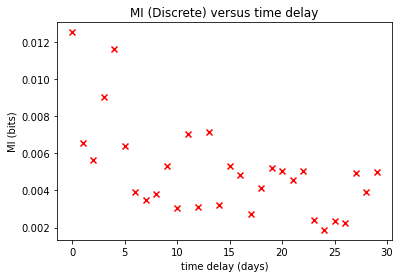

In [53]:
plt.figure();
plt.scatter(mentions_doge_grid_search_results_df.time_diff\
            , mentions_doge_grid_search_results_df.mi\
            , c='red'\
            , marker='x');
plt.title('MI (Discrete) versus time delay')
plt.xlabel('time delay (days)')
plt.ylabel('MI (bits)')

Text(0, 0.5, 'frequency')

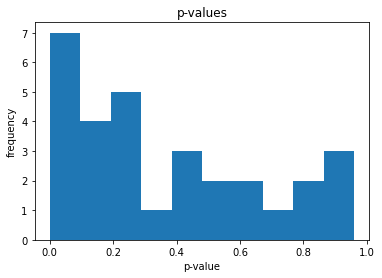

In [54]:
mentions_doge_grid_search_results_df.p_value.plot.hist()
plt.title('p-values')
plt.xlabel('p-value')
plt.ylabel('frequency')

In [55]:
mentions_doge_calc = mentions_doge_calcClass(10, 10, 0)
mentions_doge_surrogates = 1000

mentions_doge_result, mentions_doge_measDist = \
    compute_estimate_and_stat_sig(source = mentions
                                  , destination = discrete_dogecoin
                                  , calc = mentions_doge_calc
                                  , surrogate_perms = mentions_doge_surrogates
                                  , discrete=True)

print("""
    MI_Discrete(mentions -> dogecoin) = %.4f bits (log 10) 
    [null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates]
    """ %\
    (mentions_doge_result, mentions_doge_measDist.getMeanOfDistribution(), \
     mentions_doge_measDist.getStdOfDistribution(), mentions_doge_measDist.pValue, mentions_doge_surrogates))


    MI_Discrete(mentions -> dogecoin) = 0.0125 bits (log 10) 
    [null: 0.0038 +/- 0.0014 std dev.; p(surrogate > measured)=0.00000 from 1000 surrogates]
    


##  Discrete CMI : Mentions -> Dogecoin | Bitcoin

In [56]:
mentions_doge_bitcoin_calcClass = JPackage("infodynamics.measures.discrete").ConditionalMutualInformationCalculatorDiscrete
mentions_doge_bitcoin_calc = mentions_doge_bitcoin_calcClass(10, 10, 10)
mentions_doge_bitcoin_surrogates = 10000


mentions_doge_bitcoin_result, mentions_doge_bitcoin_measDist = \
    compute_estimate_and_stat_sig(source = mentions\
                                  , destination = discrete_dogecoin\
                                  , calc = mentions_doge_bitcoin_calc\
                                  , surrogate_perms = mentions_doge_bitcoin_surrogates\
                                  , conditional = discrete_bitcoin\
                                  , discrete=True)

print("""
    CMI_Discrete(mentions -> dogecoin | bitcoin) = %.4f bits (log 10) 
    [null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)]
      """ %\
    (mentions_doge_bitcoin_result, mentions_doge_bitcoin_measDist.getMeanOfDistribution(),\
     mentions_doge_bitcoin_measDist.getStdOfDistribution(), \
     mentions_doge_bitcoin_measDist.pValue, mentions_doge_bitcoin_surrogates))


    CMI_Discrete(mentions -> dogecoin | bitcoin) = 0.0138 bits (log 10) 
    [null: 0.0072 +/- 0.0022 std dev.; p(surrogate > measured)=0.00750 from 10000 surrogates)]
      


##  Discrete MI : Mentions -> Bitcoin

In [57]:
mentions_bitcoin_grid_search_results_df = \
    discrete_grid_search_timediff(source = mentions\
                                  , destination = discrete_bitcoin\
                                  , surrogate_perms = 1000)
extract_best_result(mentions_bitcoin_grid_search_results_df)

time_diff    18.000000
mi            0.009645
p_value       0.005000
Name: 18, dtype: float64

In [58]:
mentions_bitcoin_calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
mentions_bitcoin_calc = mentions_bitcoin_calcClass(10, 10, 18)
mentions_bitcoin_surrogates = 1000

mentions_bitcoin_result, mentions_bitcoin_measDist = \
    compute_estimate_and_stat_sig(source = mentions\
                                  , destination = discrete_bitcoin\
                                  , calc = mentions_bitcoin_calc\
                                  , surrogate_perms= mentions_bitcoin_surrogates\
                                  , discrete=True)

print("""
      MI_Discrete(mentions -> bitcoin) = %.4f bits (log 10) 
      [null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates]
    """ %\
    (mentions_bitcoin_result, mentions_bitcoin_measDist.getMeanOfDistribution(), \
     mentions_bitcoin_measDist.getStdOfDistribution(), mentions_bitcoin_measDist.pValue, mentions_bitcoin_surrogates))


      MI_Discrete(mentions -> bitcoin) = 0.0096 bits (log 10) 
      [null: 0.0045 +/- 0.0016 std dev.; p(surrogate > measured)=0.01000 from 1000 surrogates]
    


##  Discrete MI : Bitcoin -> Mentions

In [59]:
bitcoin_mentions_grid_search_results_df = \
    discrete_grid_search_timediff(source = discrete_bitcoin\
                                  , destination = mentions,\
                                  surrogate_perms = 1000)
extract_best_result(bitcoin_mentions_grid_search_results_df)

time_diff    1.000000
mi           0.013078
p_value      0.000000
Name: 1, dtype: float64

In [60]:
bitcoin_mentions_calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
bitcoin_mentions_calc = bitcoin_mentions_calcClass(10, 10, 1)
bitcoin_mentions_surrogates = 1000

bitcoin_mentions_result, bitcoin_mentions_measDist = \
    compute_estimate_and_stat_sig(source = discrete_bitcoin\
                                  , destination = mentions\
                                  , calc = bitcoin_mentions_calc\
                                  , surrogate_perms= mentions_bitcoin_surrogates\
                                  , discrete=True)

print("""
      MI_Discrete(bitcoin -> mentions) = %.4f bits (log 10) 
      [null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates'
    """ %\
    (bitcoin_mentions_result, bitcoin_mentions_measDist.getMeanOfDistribution(), \
     bitcoin_mentions_measDist.getStdOfDistribution(), bitcoin_mentions_measDist.pValue, bitcoin_mentions_surrogates))


      MI_Discrete(bitcoin -> mentions) = 0.0131 bits (log 10) 
      [null: 0.0044 +/- 0.0015 std dev.; p(surrogate > measured)=0.00000 from 1000 surrogates'
    


MI is symmetric. The difference betweend bitcoin -> mentions and mentions -> bitcoin is because the ideal lag is different depending on the direction.

##  Discrete MI : Bitcoin -> Dogecoin

In [61]:
doge_bitcoin_grid_search_results_df = \
    discrete_grid_search_timediff(source = discrete_bitcoin\
                                  , destination = discrete_dogecoin\
                                  , surrogate_perms=1000)
extract_best_result(doge_bitcoin_grid_search_results_df)

time_diff    0.000000
mi           0.132132
p_value      0.000000
Name: 0, dtype: float64

In [62]:
doge_bitcoin_calcClass = JPackage("infodynamics.measures.discrete").MutualInformationCalculatorDiscrete
doge_bitcoin_calc = doge_bitcoin_calcClass(10, 10, 0)
doge_bitcoin_surrogates = 1000

doge_bitcoin_result, doge_bitcoin_measDist = \
    compute_estimate_and_stat_sig(source = discrete_bitcoin\
                                  , destination = discrete_dogecoin\
                                  , calc = doge_bitcoin_calc\
                                  , surrogate_perms = doge_bitcoin_surrogates\
                                  , discrete=True)

print("""
      MI_Discrete(bitcoin -> dogecoin) = %.4f bits (log 10) 
      [null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates]
      """ %\
    (doge_bitcoin_result, doge_bitcoin_measDist.getMeanOfDistribution(), \
     doge_bitcoin_measDist.getStdOfDistribution(), doge_bitcoin_measDist.pValue, doge_bitcoin_surrogates))


      MI_Discrete(bitcoin -> dogecoin) = 0.1321 bits (log 10) 
      [null: 0.0061 +/- 0.0020 std dev.; p(surrogate > measured)=0.00000 from 1000 surrogates]
      
